# Introduction to Reinforcement Learning with Atari Games

## Workshop Overview
In this hands-on workshop, we'll dive into the exciting world of reinforcement learning (RL) by working with classic Atari games. We'll be using PettingZoo, a powerful Python library that extends the popular Gymnasium (formerly Gym) interface to support multi-agent reinforcement learning environments.

**Why Atari Games?**
- Provide a visual, intuitive way to understand RL concepts
- Offer varying levels of complexity to scale your learning
- Serve as a standard benchmark in RL research
- Feature discrete action spaces that are easier to work with for beginners

## Learning Objectives
By the end of this workshop, you will be able to:

1. **Understand RL Environments**
   - Comprehend the agent-environment interaction loop
   - Differentiate between observations, actions, and rewards
   - Understand the concept of state spaces and action spaces

2. **Set Up Atari Games with PettingZoo**
   - Initialize and configure Atari game environments
   - Handle both single-agent and multi-agent scenarios
   - Manage environment resets and episode termination

3. **Visualize Agent Behavior**
   - Render game environments in real-time
   - Observe agent decision-making processes
   - Debug and analyze agent performance

## Environment Setup

### Required Packages
Before we begin, we'll install and configure the necessary Python packages:

1. **gymnasium[accept-atari-roms]**
   - The next generation of OpenAI's Gym library
   - Provides a standard API for reinforcement learning
   - Includes support for Atari ROMs through the `accept-atari-roms` extension

2. **ale-py**
   - The Arcade Learning Environment (ALE) emulator
   - Enables running Atari 2600 games
   - Handles game ROMs and provides a clean interface for RL

3. **pettingzoo[atari]**
   - Extends Gymnasium for multi-agent environments
   - Provides pre-configured Atari game environments
   - Simplifies managing multiple agents in the same environment

4. **pygame**
   - Used for rendering the game environments
   - Provides visualization capabilities
   - Enables real-time interaction and monitoring

### Installation Notes
- The installation may take a few minutes as it includes game ROMs
- Ensure you have a stable internet connection
- Consider using a virtual environment to manage dependencies
- If you encounter any installation issues, we'll troubleshoot them together

In [ ]:
!pip install "gymnasium[accept-atari-roms]"
!pip install ale-py
!pip -q install "pettingzoo[atari]" autorom pygame==2.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.0/552.0 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 30.8 MB/s eta 0:00:00


# Setting Up Atari ROMs for Reinforcement Learning

## Why We Need AutoROM
To work with Atari games in a reinforcement learning context, we need the actual game ROMs. The `AutoROM` tool simplifies this process by:
- Automatically downloading the necessary game ROMs
- Handling the license agreement for academic use
- Placing the ROMs in the correct directory for Gymnasium/PettingZoo

## About the Command
```bash
!AutoROM --accept-license


In [ ]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms
	/usr/local/lib/python3.12/dist-packages/multi_agent_ale_py/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/multi_agent_ale_py/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/multi_agent_ale_py/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/multi_agent_ale_py/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/multi_agent_ale_py/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/multi_

Let's import the necessary Python libraries for our project:

In [ ]:
# Basic multi-agent Q-learning on Atari Mario Bros (PettingZoo) + GIF rollout
# Fixes: tie-broken argmax (avoid NOOP), step penalty & extra NOOP penalty for movement.

import os, hashlib, random
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
from pettingzoo.atari import mario_bros_v3

## Understanding Q-Learning for Atari Games

### What is Q-Learning?
Q-Learning is a fundamental reinforcement learning algorithm that enables an agent to learn optimal actions through trial and error interactions with an environment. It's particularly well-suited for environments with discrete action spaces like Atari games.

### Key Components of Our Implementation:

1. **State Representation**
   - We'll use a hashing technique to convert the game state into a compact representation
   - This helps in efficiently managing the large state spaces typical in Atari games
   - The state will capture essential game elements like Mario's position, enemies, and obstacles

2. **ε-Greedy Action Selection with NOOP Avoidance**
   - Balances exploration and exploitation using an ε (epsilon) parameter
   - With probability ε, the agent explores random actions
   - With probability 1-ε, it exploits the best-known action
   - Special handling of NOOP (no-operation) to prevent the agent from getting stuck

3. **Q-Table Implementation**
   - Stores Q-values (expected future rewards) for state-action pairs
   - Updated using the Bellman equation: 
     ```
     Q(s,a) = (1-α)Q(s,a) + α(r + γ*max(Q(s',a')))
     ```
   - Where α is the learning rate and γ is the discount factor

4. **Reward Shaping**
   - Additional rewards/penalties to guide learning
   - Encourages movement to prevent getting stuck
   - May include bonuses for collecting coins, defeating enemies, or making progress

## 5. Environment and Hyperparameter Setup

Let's set up our environment and define the hyperparameters for our Q-learning algorithm:

- `GAMMA`: Discount factor for future rewards
- `ALPHA`: Learning rate
- `EPS_START`/`EPS_END`: Exploration rate range
- `TRAIN_EPISODES`: Number of training episodes
- `MAX_AGENT_STEPS`: Maximum steps per episode

In [ ]:
ENV_KW = dict(render_mode="rgb_array")
# Try RAM observations (much smaller than pixels). If not available, it falls back automatically.
try:
    _t = mario_bros_v3.env(**ENV_KW, obs_type="ram")
    _t.reset(seed=0); _t.close()
    ENV_KW["obs_type"] = "ram"
except Exception:
    pass

env = mario_bros_v3.env(**ENV_KW)
agents = env.possible_agents

# Hyperparams
GAMMA = 0.99
ALPHA = 0.5
EPS_START = 1.0
EPS_END = 0.10             # keep a bit higher for exploration
EPS_DECAY_STEPS = 200_000  # slower decay so exploration lasts
TRAIN_EPISODES = 40
MAX_AGENT_STEPS = 5000

# Action spaces
ACTION_SPACES = {a: env.action_space(a).n for a in agents}
NOOP = 0
# Movement-biased fallback set (valid for Atari minimal action set):
# RIGHT=3, RIGHTFIRE=11, FIRE=1, UP=2, UPRIGHT=6
MOVE_PRIOR = [3, 11, 1, 2, 6]

## 6. Implementing Q-Learning Components

### 1. State Hashing
The state hashing component is crucial for managing the game's complex state space. It transforms high-dimensional observations into a manageable set of discrete states. Using the BLAKE2b hashing algorithm, it creates a consistent numerical representation of the game state while combining it with the agent's identity. This ensures each agent maintains its own perspective of the game world. The modulo operation with 100,000 buckets keeps the state space manageable while minimizing collisions.

### 2. Q-Table Initialization
The Q-table serves as the agent's memory, storing the expected future rewards for each state-action pair. For each agent, we create a two-dimensional array where rows represent states and columns represent possible actions. Initializing all values to zero represents the agent's initial lack of knowledge about the environment. As the agent interacts with the game, these values will be updated to reflect learned strategies.

### 3. Epsilon Decay
The epsilon decay mechanism controls the exploration-exploitation trade-off. Starting at 1.0 (100% exploration), it linearly decreases to 0.1 (10% exploration) over 200,000 steps. This slow, steady decay allows the agent to thoroughly explore the environment before relying more heavily on learned behaviors. The minimum 10% exploration rate ensures the agent continues to discover new strategies even in later training stages.

### 4. Action Selection
The action selection process implements an enhanced ε-greedy strategy with several key features:

- **Exploration Phase (ε% of the time)**:
  - 60% chance to choose from movement-prioritized actions (RIGHT, JUMP, etc.)
  - 40% chance to select any valid action
  - This bias towards meaningful movements helps the agent learn faster

- **Exploitation Phase (1-ε% of the time)**:
  - Selects the action with the highest expected reward
  - Breaks ties randomly to prevent action bias
  - Actively avoids the NOOP (no-operation) action when possible
  - Falls back to movement-prioritized actions when all Q-values are equal

This sophisticated action selection strategy helps the agent avoid getting stuck and encourages meaningful exploration of the game environment, leading to more effective learning of complex behaviors.

In [ ]:
# Hash-based tabular state
N_STATE_BUCKETS = 100_000
def hash_state(obs: np.ndarray, agent: str) -> int:
    import hashlib
    h = hashlib.blake2b(digest_size=8)
    h.update(agent.encode())
    h.update(np.ascontiguousarray(obs).tobytes())
    return int.from_bytes(h.digest(), "little") % N_STATE_BUCKETS

Q = {a: np.zeros((N_STATE_BUCKETS, ACTION_SPACES[a]), dtype=np.float32) for a in agents}

def epsilon_by_step(t):
    if t >= EPS_DECAY_STEPS: return EPS_END
    return EPS_START - (EPS_START - EPS_END) * (t / EPS_DECAY_STEPS)

def pick_action(q_row: np.ndarray, eps: float, n_actions: int) -> int:
    # ε-greedy with tie-broken argmax and NOOP avoidance at start.
    if random.random() < eps:
        # explore, but bias away from NOOP 60% of the time
        if random.random() < 0.6:
            choices = [a for a in MOVE_PRIOR if a < n_actions] or list(range(1, n_actions))
            return random.choice(choices)
        return random.randrange(n_actions)

    # exploit: if all q equal (start), choose a non-NOOP move
    if np.allclose(q_row, q_row[0]):
        choices = [a for a in MOVE_PRIOR if a < n_actions] or list(range(1, n_actions))
        return random.choice(choices)
    # proper argmax, but randomly break ties among maxima
    max_q = np.max(q_row)
    best = np.flatnonzero(q_row == max_q)
    # avoid picking NOOP on tie if we have alternatives
    if len(best) > 1 and NOOP in best and len(best) > 1:
        best = [b for b in best if b != NOOP] or best
    return int(random.choice(best))

## 7. Training the Q-Learning Agent

### Training Process Overview
The training phase is where our Q-learning agent develops its strategy through repeated interactions with the environment. This section details the key components of our training loop and their significance.

### Core Training Components

1. **Environment Interaction**
   - The agent observes the current game state
   - Selects actions based on the ε-greedy policy
   - Executes actions and receives feedback (new state and reward)
   - Transitions between states while accumulating rewards

2. **Q-Value Updates**
   - Implements the Q-learning update rule:
     ```
     Q(s,a) = (1-α)Q(s,a) + α(r + γ*max(Q(s',a')))
     ```
   - Updates are based on the immediate reward plus discounted future rewards
   - Learning rate (α) controls how quickly new information overrides old knowledge

3. **Exploration Management**
   - Starts with high exploration (ε = 1.0)
   - Gradually reduces exploration according to our decay schedule
   - Maintains a minimum exploration rate (ε = 0.1) to ensure continued learning

4. **Performance Tracking**
   - Records episode returns (total rewards per episode)
   - Tracks exploration rate over time
   - Monitors Q-value stability as learning progresses

### Training Dynamics
- **Early Training**: Agent explores randomly, collecting diverse experiences
- **Mid-Training**: Begins to recognize valuable state-action pairs
- **Later Stages**: Exploits learned knowledge while maintaining some exploration

### Implementation Considerations
- Handles both single and multi-agent scenarios
- Efficiently manages state space through hashing
- Includes safeguards against getting stuck in local optima
- Provides real-time feedback on training progress

### Expected Outcomes
- Gradual increase in episode returns
- More consistent and goal-directed behavior over time
- Development of strategies that maximize long-term rewards
- Emergence of complex behaviors through simple reward signals

The training process transforms our initially naive agent into a capable player through the power of reinforcement learning, demonstrating how simple learning rules can lead to sophisticated behaviors in complex environments.

In [ ]:
global_step = 0

# Training loop
for ep in range(TRAIN_EPISODES):
    env.reset(seed=ep)
    ep_return = {a: 0.0 for a in agents}
    agent_steps = 0

    for agent in env.agent_iter(max_iter=MAX_AGENT_STEPS):
        obs, reward, terminated, truncated, info = env.last()

        # Reward shaping
        shaped = float(reward) - 0.01  # Small step cost

        if terminated or truncated:
            env.step(None)
            continue

        s = hash_state(obs, agent)
        eps = epsilon_by_step(global_step)
        a = pick_action(Q[agent][s], eps, ACTION_SPACES[agent])

        # Take action
        env.step(a)

        # Get next observation and reward
        next_obs, next_reward, next_term, next_trunc, _ = env.last()

        # Extra penalty for NOOP
        if a == NOOP:
            shaped -= 0.04

        r_total = shaped

        # Q-learning update
        if next_term or next_trunc:
            target = r_total
        else:
            s_next = hash_state(next_obs, agent)
            target = r_total + GAMMA * float(np.max(Q[agent][s_next]))

        Q[agent][s, a] += ALPHA * (target - Q[agent][s, a])

        ep_return[agent] += float(next_reward)
        global_step += 1
        agent_steps += 1
        if agent_steps >= MAX_AGENT_STEPS:
            break

    if (ep + 1) % 5 == 0:
        print(f"Episode {ep+1}/{TRAIN_EPISODES} | env return sum={sum(ep_return.values()):.1f} | eps={epsilon_by_step(global_step):.3f}")

env.close()

Episode 5/40 | env return sum=0.0 | eps=0.898
Episode 10/40 | env return sum=0.0 | eps=0.785
Episode 15/40 | env return sum=0.0 | eps=0.673
Episode 20/40 | env return sum=0.0 | eps=0.574
Episode 25/40 | env return sum=0.0 | eps=0.470
Episode 30/40 | env return sum=0.0 | eps=0.359
Episode 35/40 | env return sum=0.0 | eps=0.247
Episode 40/40 | env return sum=0.0 | eps=0.135


## 8. Visualizing the Trained Agent

Let's see how our trained agent performs! We'll:
1. Create a new environment for evaluation
2. Run a greedy policy (no exploration)
3. Generate a GIF of the agent's performance

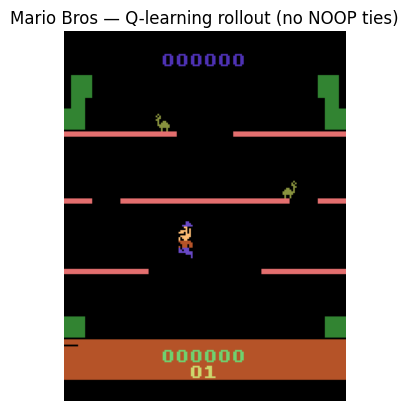

Saved GIF to mario_bros_qlearning.gif


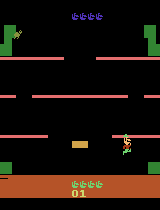

In [ ]:
# Greedy rollout (no exploration) + GIF
env = mario_bros_v3.env(render_mode="rgb_array", **({} if "obs_type" not in ENV_KW else {"obs_type": ENV_KW["obs_type"]}))
env.reset(seed=123)

frames = []
ROLLOUT_STEPS = 800
for _ in range(ROLLOUT_STEPS):
    # Small inner loop to advance both agents per captured frame
    for agent in env.agent_iter(max_iter=2):
        obs, reward, terminated, truncated, info = env.last()
        if terminated or truncated:
            env.step(None)
            continue
        s = hash_state(obs, agent)
        qrow = Q[agent][s]
        # Greedy but tie-broken away from NOOP
        if np.allclose(qrow, qrow[0]):
            a = random.choice([x for x in MOVE_PRIOR if x < ACTION_SPACES[agent]] or list(range(1, ACTION_SPACES[agent])))
        else:
            max_q = np.max(qrow)
            best = np.flatnonzero(qrow == max_q)
            if NOOP in best and len(best) > 1:
                best = [b for b in best if b != NOOP] or best
            a = int(random.choice(best))
        env.step(a)
    frames.append(env.render())

env.close()

# Display the final frame
plt.imshow(frames[-1])
plt.axis("off")
plt.title("Mario Bros — Q-learning rollout (no NOOP ties)")
plt.show()

# Save and display GIF
gif_path = "mario_bros_qlearning.gif"
imageio.mimsave(gif_path, frames, fps=30)
print(f"Saved GIF to {gif_path}")
display(Image(filename=gif_path))

## 9. Advanced Q-Learning with Wall-Clock Budget

### Enhanced Training Approach
This section introduces a more sophisticated implementation of our Q-learning agent, featuring several key improvements designed to enhance training efficiency and effectiveness.

#### Key Enhancements:
1. **Time-Based Training**
   - Trains for a fixed wall-clock duration (default: 150 seconds)
   - More practical than fixed episode counts for real-world applications
   - Allows for consistent comparison across different hardware

2. **Optimized Performance**
   - Utilizes RAM observations when available for faster processing
   - Reduces computational overhead compared to pixel-based observations
   - Enables more training iterations within the same time frame

3. **Improved Exploration Strategy**
   - Implements a slower epsilon decay schedule (400,000 steps)
   - Maintains exploration for a longer duration
   - Helps discover better strategies in complex environments

4. **Enhanced State Representation**
   - Expands state space to 150,000 buckets
   - Reduces hash collisions
   - Provides more precise state discrimination

5. **Model Persistence**
   - Includes checkpointing functionality
   - Saves the learned Q-table at regular intervals
   - Enables training resumption and model deployment

### Implementation Architecture
- **Modular Design**: Separates configuration, helper functions, and training logic
- **Efficient State Management**: Optimized hashing for quick state lookups
- **Resource Management**: Handles memory and computation efficiently
- **Reproducibility**: Maintains consistent behavior across runs

This advanced implementation is designed to maximize learning efficiency while providing robust performance across different game scenarios.

### 9.1 Configuration and Helper Functions

#### Configuration Parameters
The following parameters control the training behavior and agent performance:

1. **Training Parameters**
   - `TRAIN_WALLTIME_SEC = 150`: Total training duration in seconds
   - `MAX_AGENT_STEPS = 6000`: Maximum steps per episode
   - `GAMMA = 0.99`: Discount factor for future rewards
   - `ALPHA = 0.5`: Learning rate

2. **Exploration Parameters**
   - `EPS_START = 1.0`: Initial exploration rate
   - `EPS_END = 0.10`: Minimum exploration rate
   - `EPS_DECAY_STEPS = 400_000`: Steps over which exploration decays

3. **State Space Configuration**
   - `N_STATE_BUCKETS = 150_000`: Size of state space
   - `NOOP = 0`: Action code for no operation
   - `MOVE_PRIOR = [3, 11, 1, 2, 6]`: Priority-ordered action set

#### Core Helper Functions

1. **State Hashing (`hash_state`)**
   - Converts game observations to state indices
   - Uses BLAKE2b hashing for efficient state representation
   - Combines agent identity with observation data
   - Ensures consistent state mapping across episodes

2. **Epsilon Scheduling (`epsilon_by_step`)**
   - Implements linear decay of exploration rate
   - Maintains minimum exploration for continuous learning
   - Smoothly transitions from exploration to exploitation

3. **Action Selection (`pick_action`)**
   - Implements ε-greedy policy with NOOP avoidance
   - Biases exploration towards meaningful game actions
   - Handles edge cases and tie-breaking
   - Maintains exploration even during exploitation phase

#### Implementation Notes
- **Efficiency**: Optimized for performance in the Atari environment
- **Robustness**: Includes safeguards against common edge cases
- **Flexibility**: Parameters can be easily adjusted for different scenarios
- **Reproducibility**: Deterministic behavior where appropriate

These components work together to create a robust and efficient learning system that can adapt to the challenges of the Mario Bros environment.

In [ ]:
# Advanced Q-learning with wall-clock budget for Atari Mario Bros
# Runs for >= TRAIN_WALLTIME_SEC (defaults 150s), then renders a greedy rollout to a GIF.

import os, time, random, numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
from pettingzoo.atari import mario_bros_v3

# ---------------------------
# Config
# ---------------------------
TRAIN_WALLTIME_SEC = 150       # >= 2 minutes; bump if you want more
MAX_AGENT_STEPS = 6000         # per episode cap across both agents
GAMMA = 0.99
ALPHA = 0.5
EPS_START = 1.0
EPS_END = 0.10
EPS_DECAY_STEPS = 400_000      # slower decay to keep exploring longer
N_STATE_BUCKETS = 150_000      # Q-table buckets per agent
NOOP = 0
MOVE_PRIOR = [3, 11, 1, 2, 6]  # RIGHT, RIGHTFIRE, FIRE, UP, UPRIGHT (bias away from standing still)

# ---------------------------
# Helper functions
# ---------------------------
def hash_state(obs: np.ndarray, agent: str) -> int:
    import hashlib
    h = hashlib.blake2b(digest_size=8)
    h.update(agent.encode())
    h.update(np.ascontiguousarray(obs).tobytes())
    return int.from_bytes(h.digest(), "little") % N_STATE_BUCKETS

def epsilon_by_step(t):
    if t >= EPS_DECAY_STEPS: return EPS_END
    return EPS_START - (EPS_START - EPS_END) * (t / EPS_DECAY_STEPS)

def pick_action(q_row: np.ndarray, eps: float, n_actions: int) -> int:
    # ε-greedy with tie-broken argmax and NOOP avoidance at start/ties.
    if random.random() < eps:
        if random.random() < 0.6:  # bias explore toward movement
            choices = [a for a in MOVE_PRIOR if a < n_actions] or list(range(1, n_actions))
            return random.choice(choices)
        return random.randrange(n_actions)
    # exploit:
    if np.allclose(q_row, qrow[0]):  # all equal → avoid NOOP
        choices = [a for a in MOVE_PRIOR if a < n_actions] or list(range(1, n_actions))
        return random.choice(choices)
    max_q = np.max(q_row)
    best = np.flatnonzero(q_row == max_q)
    if NOOP in best and len(best) > 1:
        best = [b for b in best if b != NOOP] or best
    return int(random.choice(best))

### 9.2 Environment Setup

We'll set up our training environment to use RAM observations when available for faster training. This is particularly important when working with a time budget.

In [ ]:
# Build fast training env (no rendering)
train_env_kwargs = dict(render_mode=None)
# Try RAM (faster/low-dim). If not supported, fallback silently.
try:
    _t = mario_bros_v3.env(**train_env_kwargs, obs_type="ram")
    _t.reset(seed=0); _t.close()
    train_env_kwargs["obs_type"] = "ram"
    using_ram = True
except Exception:
    using_ram = False

env = mario_bros_v3.env(**train_env_kwargs)
agents = env.possible_agents
ACTION_SPACES = {a: env.action_space(a).n for a in agents}
Q = {a: np.zeros((N_STATE_BUCKETS, ACTION_SPACES[a]), dtype=np.float32) for a in agents}

### 9.3 Training Loop with Wall-Clock Budget

#### Core Training Loop Architecture
The training loop has been enhanced with several key features that make it more robust and practical for real-world applications:

1. **Time-Based Training**
   - Runs for a fixed wall-clock duration (default: 150 seconds)
   - More practical than fixed episode counts
   - Ensures consistent training time across different hardware

2. **Efficient Resource Management**
   - Checks wall-clock time every 2000 steps to minimize overhead
   - Gracefully handles episode termination and truncation
   - Maintains performance counters and metrics

3. **Reward Shaping**
   - Implements a small negative reward (-0.01) for each step
   - Applies an additional penalty (-0.04) for NOOP actions
   - Encourages the agent to make meaningful progress

4. **Learning Process**
   - Implements the Q-learning update rule
   - Handles terminal states appropriately
   - Updates Q-values based on observed rewards and next states

#### Key Components

1. **Episode Management**
   ```python
   while True:
       episode += 1
       env.reset(seed=episode)
       ep_return = {a: 0.0 for a in agents}

In [ ]:
# Training loop (wall-clock budget)
start = time.time()
global_step = 0
episode = 0
rolling_returns = []

print(f"Training start — RAM mode: {using_ram}, walltime ≥ {TRAIN_WALLTIME_SEC}s")

while True:
    episode += 1
    env.reset(seed=episode)
    ep_return = {a: 0.0 for a in agents}
    agent_steps = 0

    for agent in env.agent_iter(max_iter=MAX_AGENT_STEPS):
        obs, reward, terminated, truncated, info = env.last()

        # Reward shaping (tiny step cost + extra NOOP penalty after action)
        shaped = float(reward) - 0.01

        if terminated or truncated:
            env.step(None)
            continue

        s = hash_state(obs, agent)
        eps = epsilon_by_step(global_step)
        a = pick_action(Q[agent][s], eps, ACTION_SPACES[agent])

        env.step(a)
        next_obs, next_reward, next_term, next_trunc, _ = env.last()

        if a == NOOP:
            shaped -= 0.04

        r_total = shaped

        # Q-learning update
        if next_term or next_trunc:
            target = r_total
        else:
            s_next = hash_state(next_obs, agent)
            target = r_total + GAMMA * float(np.max(Q[agent][s_next]))

        Q[agent][s, a] += ALPHA * (target - Q[agent][s, a])
        ep_return[agent] += float(next_reward)

        global_step += 1
        agent_steps += 1
        # wallclock check every ~few thousand steps to avoid overhead
        if agent_steps % 2000 == 0 and (time.time() - start) >= TRAIN_WALLTIME_SEC:
            break

    rolling_returns.append(sum(ep_return.values()))
    if episode % 5 == 0:
        mean_last = np.mean(rolling_returns[-5:])
        print(f"Ep {episode:4d} | last5 avg return: {mean_last:7.2f} | eps={epsilon_by_step(global_step):.3f} | steps={global_step}")

    # stop if time budget reached
    if (time.time() - start) >= TRAIN_WALLTIME_SEC:
        break

env.close()
print(f"Training done in {time.time() - start:.1f}s, episodes={episode}, steps={global_step}")

# Save Q-table checkpoint
np.save("qtable_mario_bros.npy", {a: Q[a] for a in agents}, allow_pickle=True)
print("Saved Q-table to qtable_mario_bros.npy")

Training start — RAM mode: True, walltime ≥ 150s
Ep    5 | last5 avg return:  480.00 | eps=0.937 | steps=27920
Ep   10 | last5 avg return:  640.00 | eps=0.878 | steps=54271
Ep   15 | last5 avg return: 1280.00 | eps=0.818 | steps=80779
Ep   20 | last5 avg return:  640.00 | eps=0.755 | steps=108688
Ep   25 | last5 avg return: 1600.00 | eps=0.695 | steps=135339
Ep   30 | last5 avg return: 1600.00 | eps=0.646 | steps=157463
Ep   35 | last5 avg return:  160.00 | eps=0.596 | steps=179541
Ep   40 | last5 avg return: 1120.00 | eps=0.546 | steps=201804
Ep   45 | last5 avg return:  160.00 | eps=0.497 | steps=223442
Ep   50 | last5 avg return:  320.00 | eps=0.436 | steps=250664
Ep   55 | last5 avg return: 1280.00 | eps=0.379 | steps=276142
Ep   60 | last5 avg return:  160.00 | eps=0.336 | steps=295039
Ep   65 | last5 avg return: 1120.00 | eps=0.274 | steps=322509
Ep   70 | last5 avg return:  640.00 | eps=0.215 | steps=348974
Ep   75 | last5 avg return:  480.00 | eps=0.152 | steps=377036
Ep   80 |

### 9.4 Greedy Rollout and Visualization

Let's visualize how our trained agent performs with a greedy policy (no exploration). We'll generate a GIF to see the agent's behavior.

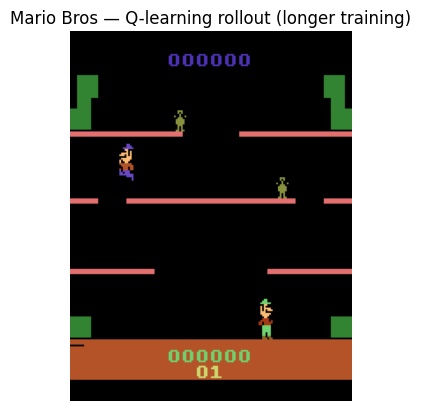

Saved GIF to mario_bros_qlearning_long.gif


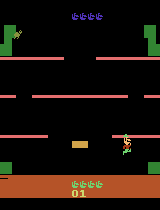

In [ ]:
# Greedy rollout + GIF (rendering enabled)
roll_kwargs = {}
if using_ram:
    roll_kwargs["obs_type"] = "ram"

env = mario_bros_v3.env(render_mode="rgb_array", **roll_kwargs)
env.reset(seed=123)

frames = []
ROLLOUT_STEPS = 900
for _ in range(ROLLOUT_STEPS):
    for agent in env.agent_iter(max_iter=2):
        obs, reward, terminated, truncated, info = env.last()
        if terminated or truncated:
            env.step(None)
            continue
        s = hash_state(obs, agent)
        qrow = Q[agent][s]
        if np.allclose(qrow, qrow[0]):
            # tie-break greedily away from NOOP
            choices = [x for x in MOVE_PRIOR if x < ACTION_SPACES[agent]] or list(range(1, ACTION_SPACES[agent]))
            a = random.choice(choices)
        else:
            max_q = np.max(qrow)
            best = np.flatnonzero(qrow == max_q)
            if NOOP in best and len(best) > 1:
                best = [b for b in best if b != NOOP] or best
            a = int(random.choice(best))
        env.step(a)
    frames.append(env.render())

env.close()

# Display the final frame
plt.imshow(frames[-1])
plt.axis("off")
plt.title("Mario Bros — Q-learning rollout (longer training)")
plt.show()

# Save and display GIF
gif_path = "mario_bros_qlearning_long.gif"
imageio.mimsave(gif_path, frames, fps=30)
print(f"Saved GIF to {gif_path}")
display(Image(filename=gif_path))

## 10. Analysis and Discussion

**Key Improvements in This Implementation:**

1. **Wall-Clock Time Budget**:
   - Trains for a fixed duration (default: 150 seconds)
   - More predictable training time compared to fixed episodes
   - Allows for better resource management

2. **Performance Optimizations**:
   - Uses RAM observations when available (faster than pixel observations)
   - Efficient state hashing with a larger state space (150,000 buckets)
   - Periodic progress reporting

3. **Enhanced Exploration**:
   - Slower epsilon decay (400,000 steps) for sustained exploration
   - Biased action selection towards movement actions
   - NOOP (no operation) penalty to encourage active behavior

**Observations:**
- How does the agent's performance compare to the previous implementation?
- Does the agent learn more complex behaviors with longer training?
- Are there any limitations to the tabular Q-learning approach?

**Potential Enhancements:**
1. Implement experience replay for better sample efficiency
2. Try function approximation (e.g., neural networks) instead of tabular Q-learning
3. Experiment with different reward shaping strategies
4. Add curriculum learning to tackle more complex tasks

## 11. Conclusion and Next Steps

In this advanced implementation, we've enhanced our Q-learning agent with several key improvements:

1. **Time-based Training**: The agent now trains for a fixed wall-clock duration, making the training process more predictable.
2. **Performance Optimizations**: By using RAM observations when available and optimizing the state representation, we've made training more efficient.
3. **Enhanced Exploration**: The agent now explores more effectively with a slower epsilon decay and action biasing.

**Key Takeaways:**
- Reinforcement learning requires careful tuning of hyperparameters
- Reward shaping can significantly impact learning
- Efficient state representation is crucial for learning in complex environments

**Next Steps:**
1. Experiment with different hyperparameter values
2. Implement Deep Q-Networks (DQN) for better performance
3. Try the agent on other Atari games
4. Explore multi-agent coordination strategies

**Further Reading:**
- [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236)
- [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
- [PettingZoo Documentation](https://pettingzoo.farama.org/)

Let's explore the Mario Bros environment. We'll use the following parameters:
- `render_mode="rgb_array"`: To get the game frames as numpy arrays
- `max_cycles=1000`: To limit the maximum number of steps per episode